In [644]:
import numpy as np
from tools import *
from fitters import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (10,7)})
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [645]:
n_series = 4
series_rank = 2
shape = (n_series, series_rank)
a_s = np.random.uniform(-2, 2, size=shape)
e_s = np.random.uniform(-2, 2, size=shape)

noise = 1e-7
beta = 1e-7
start_end = (-3, 3)
dt = 0.1
dim = 30
window_factor = 2.0

time = np.arange(start_end[0], start_end[1]+dt, dt)

X0s = []
Xps = []
X_series_s, Y_series_s = [], []

for i in range(n_series):
    X_series, Y_series, _, _ = build_exp_series(
        a_s[i], e_s[i], noise=noise, time=time)

    if len(X_series_s) > 0:
        shift = X_series_s[-1][-1]-X_series[0]
        X_series += shift
        Y_series += shift

    Xhan = build_hankel(X_series, dim)
    X_series_s.append(X_series)
    Y_series_s.append(Y_series)

X_series = np.concatenate(X_series_s)
Y_series = np.concatenate(Y_series_s)

N = len(X_series)
window = int(dim * window_factor)
thetas, ws, ress = [], [], []
for i in range(window, N, 1):

    sl = slice(i-window, i)
    Xhan = build_hankel(X_series[sl], dim)
    X0w = Xhan[:, :-1]
    Xpw = Xhan[:, 1:]

    Xp1 = Xpw[-1]
    X01 = np.vstack((X0w, np.ones(X0w.shape[1])))
    reg_dim = dim + 1
    lam = beta * np.eye(reg_dim)

    a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)
    a = scipy.linalg.lstsq(X01.T, Xp1)[0]
    a, c = a[:-1], a[-1:]
    A = np.eye(dim, k=1)
    A[-1] = a
    w, vl = scipy.linalg.eig(A, left=True, right=False)

    c_col = np.zeros((A.shape[1], 1))
    c_col[-1] = c
    A = np.concatenate((A, c_col), axis=1)
    res = np.linalg.norm(Xpw-(A @ X01))

    sortorder = np.argsort(np.abs(w))
    w = w[sortorder][::-1]
    theta = vl[:, sortorder][:, -1]
    theta *= np.sign(theta[-1])
    thetas.append(theta)
    ws.append(w)
    ress.append(res)

ress = np.array(ress)
ws = np.array(ws)
thetas = np.array(thetas)
Xhan = build_hankel(X_series, dim)
theta = np.mean(thetas, axis=0)
P_series = theta.real @ Xhan


P_series_b, theta_b, A, c = eig_companion_Cshift(X_series, dim, beta=beta)


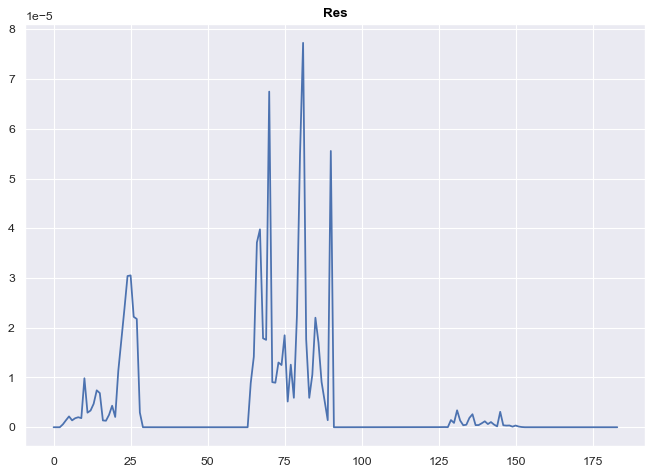

In [646]:
plt.plot(ress)
plt.title('Res')
plt.show()

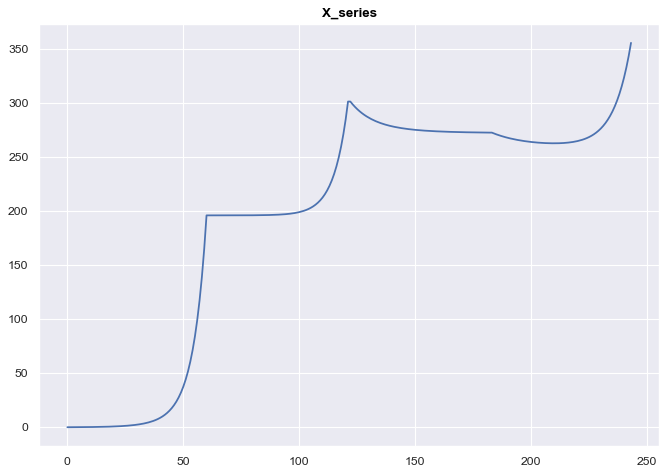

In [647]:
plt.plot(X_series);
plt.title('X_series')
plt.show()

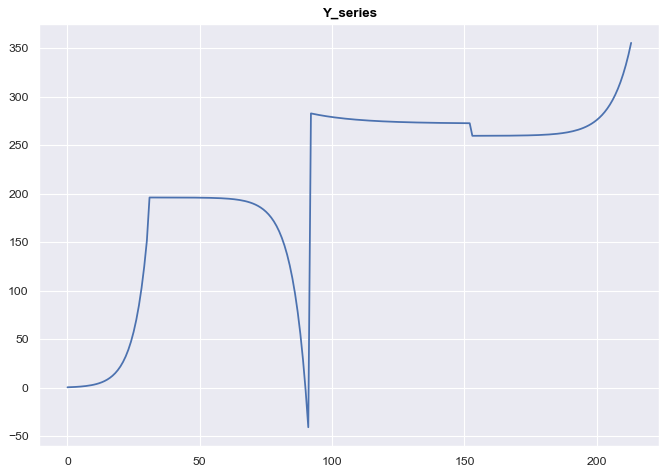

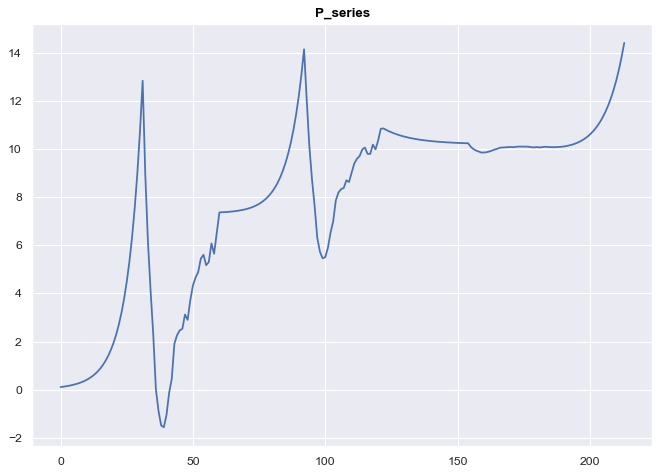

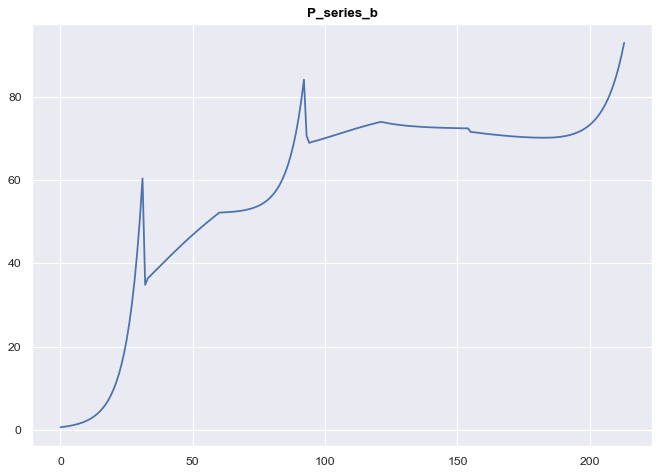

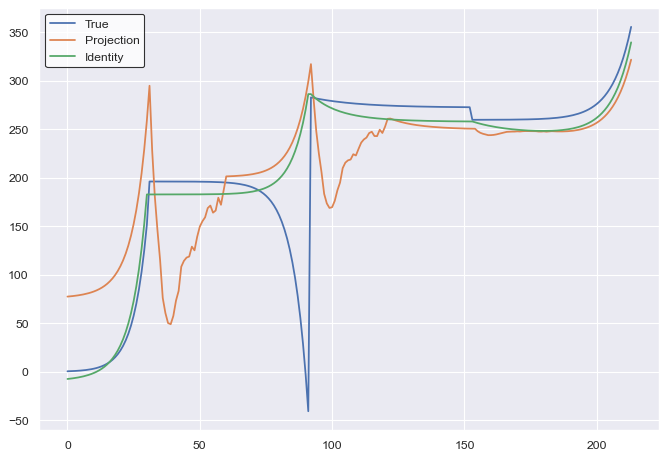

In [648]:
# plt.plot(theta.real)
# plt.show()



plt.plot(Y_series[dim:])
plt.title('Y_series')
plt.show()

plt.plot(P_series)
plt.title('P_series')
plt.show()
plt.plot(P_series_b)
plt.title('P_series_b')
plt.show()
P_series_fit = solve_scale_shift(P_series, Y_series[dim:])
X_series_fit = solve_scale_shift(X_series[dim:], Y_series[dim:])
plt.plot(Y_series[dim:], label='True')
plt.plot(P_series_fit, label='Projection')
plt.plot(X_series_fit, label='Identity')
plt.legend()
plt.show()



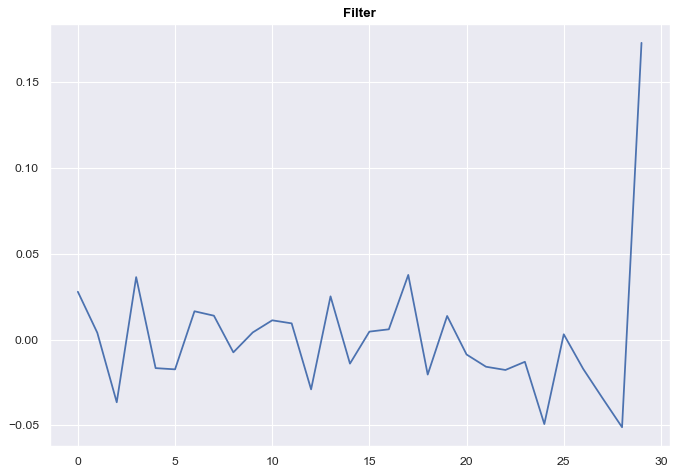

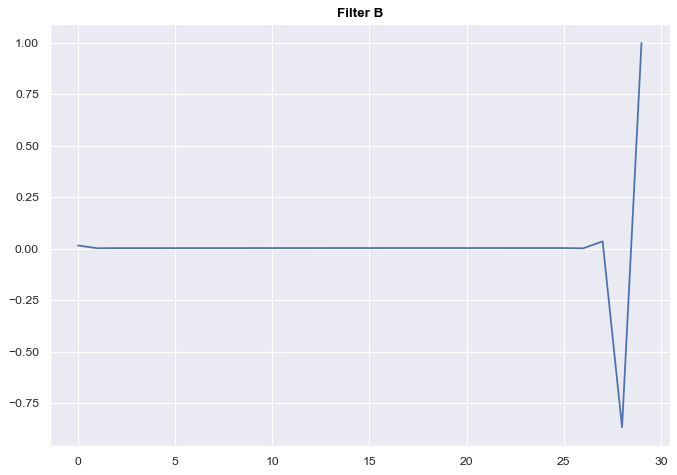

In [649]:
plt.plot(theta.real)
plt.title('Filter')
plt.show()
plt.plot(theta_b.real)
plt.title('Filter B')
plt.show()